In [3]:
import os
import cufflinks
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

# 1. Data load

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 사용자-영화-평점 데이터가 저장된 'rating.dat', 'movies.dat' 데이터를 CSV 형식으로 가공 후, 데이터의 내용을 확인한다.
    
</span>

# 1.1 User data load

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 사용자의 평점 데이터가 저장된 'rating.dat' 데이터를 CSV 형식으로 가공 후, 데이터의 내용을 확인한다.
    
</span>

In [4]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']

ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")

orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 불러온 데이터는 유저ID, 영화ID, 별점, 작성시간으로 총 4가지 정보를 가지고 있다.
    
</span>

In [5]:
del ratings['timestamp']
ratings.head()

,user_id,movie_id,ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 영화 추천 시스템에 리뷰 작성 시간은 필요없는 정보라 생각하여 해당 컬럼을 삭제했다.
    
</span>

# 1.2 Movie data load

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 영화의 데이터가 저장된 'movies.dat' 데이터를 CSV 형식으로 가공 후, 데이터의 내용을 확인한다.
    
</span>

In [6]:
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 불러온 데이터는 영화ID, 영화 이름, 장르, 총 3가지 정보를 가지고 있다.
    
</span>

## 1.3 Check missing values

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 불러온 데이터에 결측치가 있는지 확인하는 작업을 수행한다.
    
</span>

### 1.3.1 check ratings data

<AxesSubplot:>

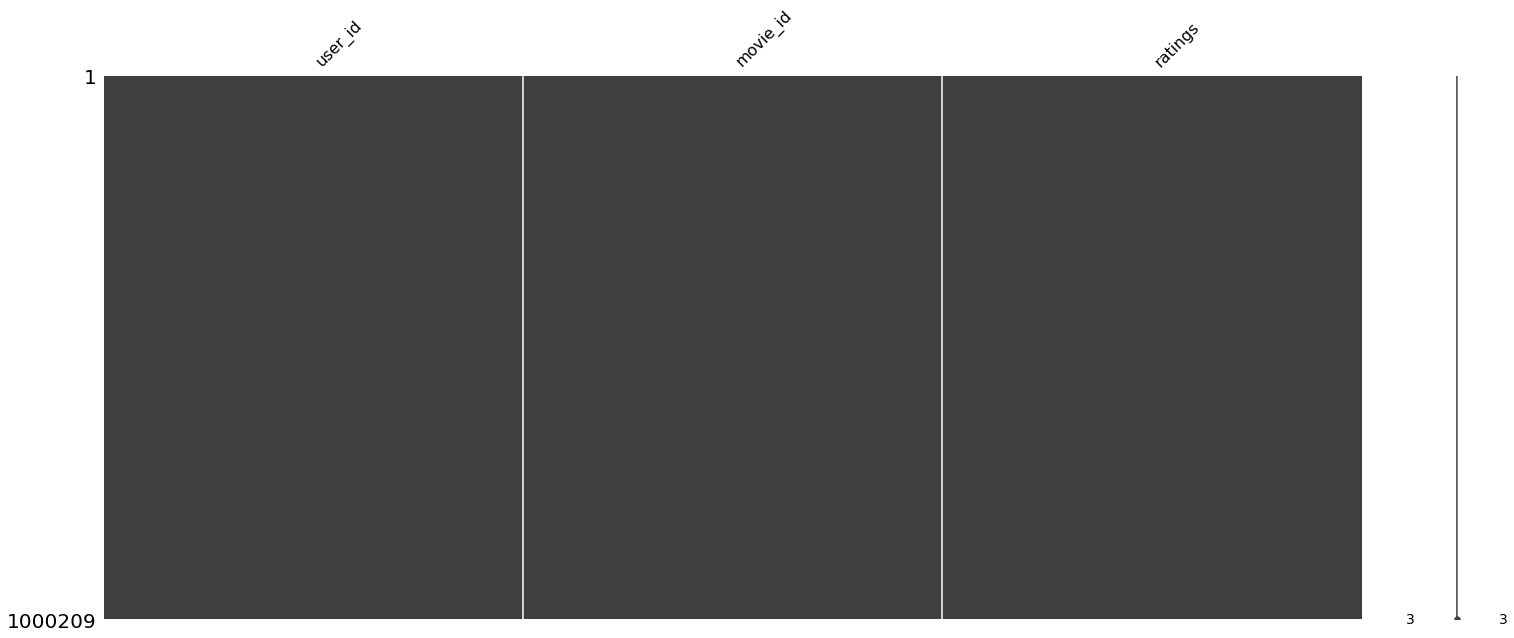

In [7]:
msno.matrix(ratings)

<AxesSubplot:>

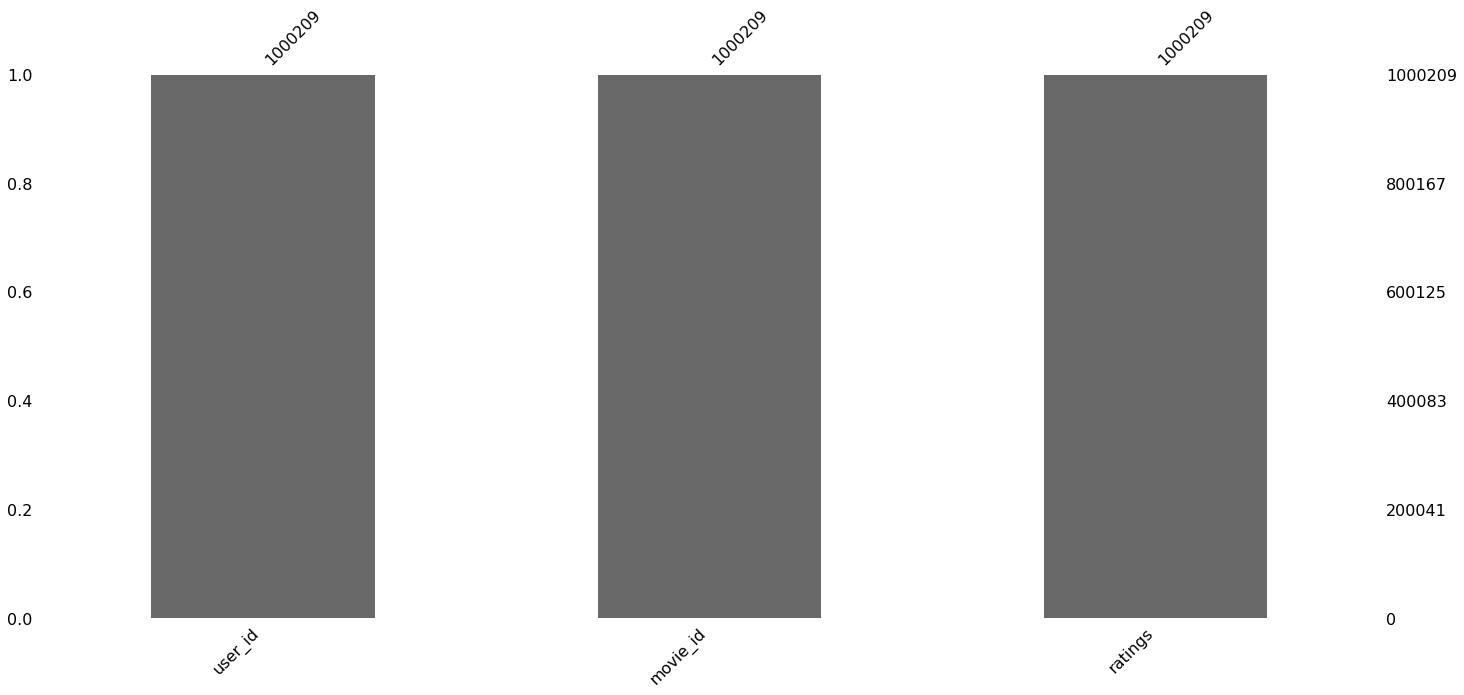

In [8]:
msno.bar(ratings)

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> rating 데이터는 시각적, 수치적 분석에서 결측치가 관찰되지 않았다.
    
</span>

### 1.3.2 check movies data

<AxesSubplot:>

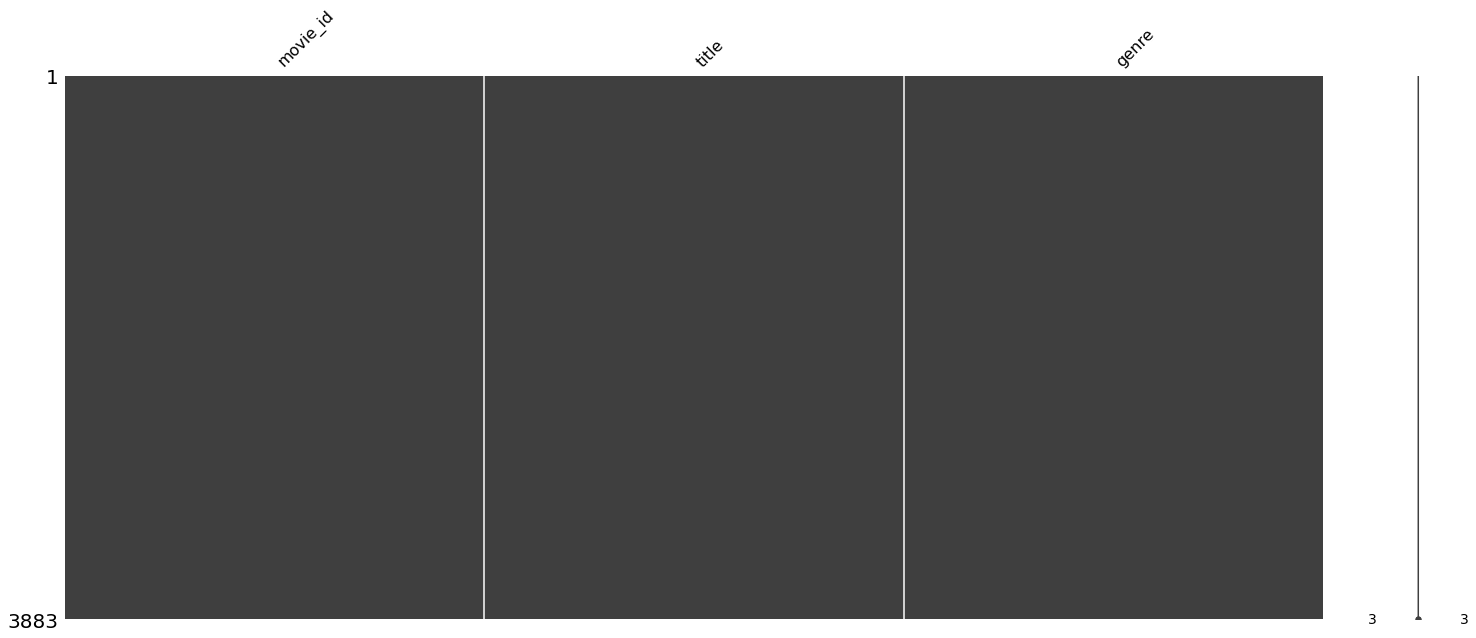

In [9]:
msno.matrix(movies)

<AxesSubplot:>

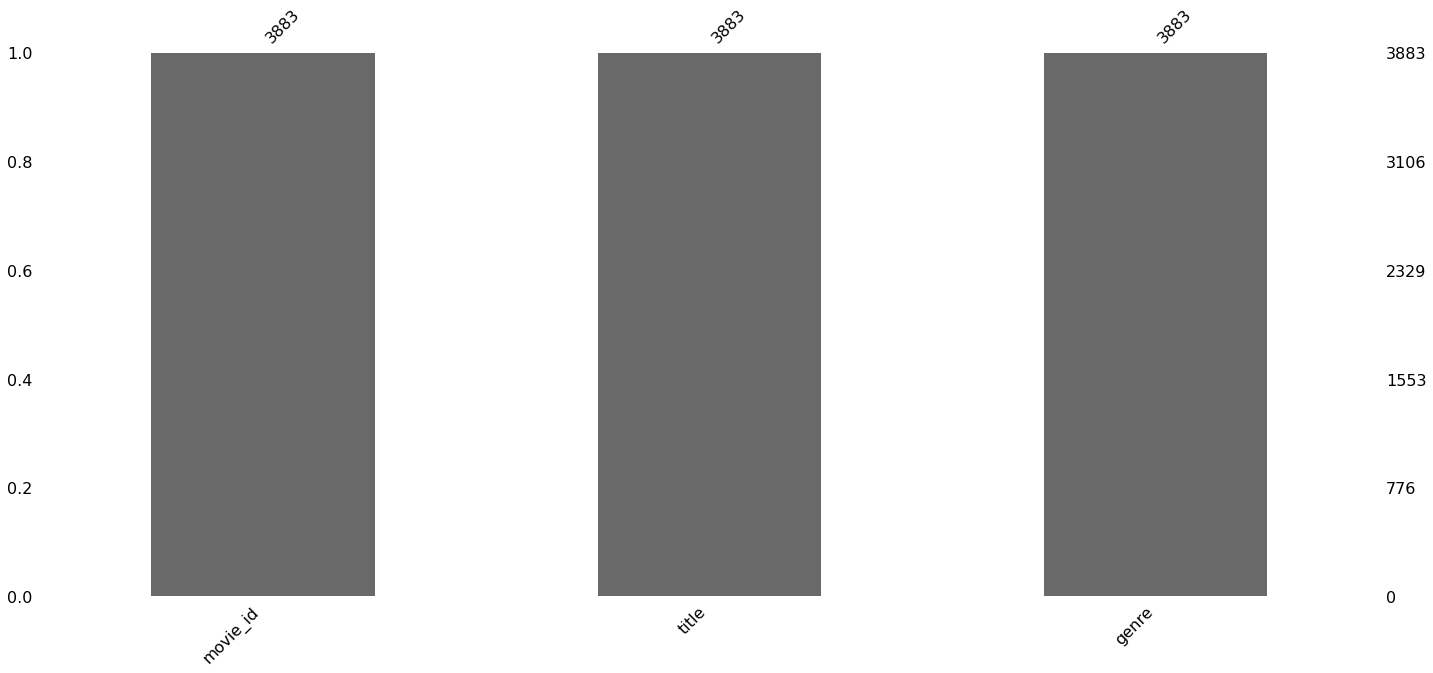

In [10]:
msno.bar(movies)

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> movies 데이터에도 시각적, 수치적 분석에서 결측치가 관찰되지 않았다.
    
</span>

# 2. Data preprocessing

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 기획단계에서 유저가 3점 미만으로 준 데이터는 해당 영화를 선호하지 않는다고 가정하고 제외하기로 했으므로,<br> 별점이 3점 이상인 데이터만 추출하는 과정을 수행한다
    
</span>

In [11]:
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 전처리 이후 평점이 3점 이상인 데이터는 83.63%로, 16.37%의 데이터가 3점 미만이였음을 확인할 수 있다.
    
</span>

In [12]:
print(f'원본 데이터 개수: {orginal_data_size}')
print(f'전처리 작업 후 데이터 개수: {filtered_data_size}')
print(f'평점이 3점 이상인 데이터의 비율 : {filtered_data_size / orginal_data_size:.2%}')

원본 데이터 개수: 1000209
전처리 작업 후 데이터 개수: 836478
평점이 3점 이상인 데이터의 비율 : 83.63%


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 기획단계에서 별점을 시청횟수로 정의하기로 했으므로, ratings 컬럼의 이름을 counts로 변환하는 과정을 수행한다
    
</span>

In [13]:
ratings.rename(columns={'ratings':'counts'}, inplace=True)
ratings.head()

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


## 3. Exploratory data analysis

### 3.1. 별점(리뷰)에 있는 유니크한 사용자 수

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 전체 리뷰 중 유저의 수를 확인하는 과정을 수행했다.
    
</span>

In [14]:
print('유저 리뷰 수 : {}명'.format(len(ratings['user_id'])))
print('유저 수 : {}명'.format(ratings['user_id'].nunique()))

유저 리뷰 수 : 836478명
유저 수 : 6039명


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 리뷰를 많이 쓴 유저도 궁금하여 리뷰어TOP10을 확인하는 과정을 수행했다.
    
</span>

In [15]:
x = ratings['user_id'].value_counts().reset_index()
x.rename(columns={'user_id':'review_count'}, inplace=True)
x.rename(columns={'index':'user_id'}, inplace=True)
x[:10]

,user_id,review_count
0,4169,1968
1,4277,1715
2,1680,1515
3,3618,1146
4,1015,1145
5,5831,1136
6,2909,1119
7,1941,1116
8,424,1106
9,1980,1054


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 랭킹 10위권 유저는 리뷰를 1000회 이상 작성했음을 확인할 수 있다.<br>랭킹 1위는 2000회에 근접한 리뷰를 작성한 위엄을 보여주었다.
    
</span>

### 3.2. 별점(리뷰)에 있는 유니크한 영화 개수

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 전체 리뷰 중 영화의 개수를 확인하는 과정을 수행했다.
    
</span>

In [16]:
print('영화 리뷰 개수 : {}개'.format(len(ratings['movie_id'])))
print('영화 수 : {}편'.format(ratings['movie_id'].nunique()))

영화 리뷰 개수 : 836478개
영화 수 : 3628편


### 3.3. 가장 인기 있는 영화 TOP30(리뷰 개수 순)

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 리뷰가 많이 작성된 영화도 궁금하여 리뷰 많은 영화TOP30을 확인하는 과정을 수행했다.
    
</span>

In [17]:
x = ratings['movie_id'].value_counts().reset_index()
x.rename(columns={'movie_id':'review_count'}, inplace=True)
x.rename(columns={'index':'movie_id'}, inplace=True)
x = pd.merge(x, movies)
x.head(30)

,movie_id,review_count,title,genre
0,2858,3211,American Beauty (1999),Comedy|Drama
1,260,2910,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
2,1196,2885,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
3,1210,2716,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
4,2028,2561,Saving Private Ryan (1998),Action|Drama|War
5,589,2509,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
6,593,2498,"Silence of the Lambs, The (1991)",Drama|Thriller
7,1198,2473,Raiders of the Lost Ark (1981),Action|Adventure
8,1270,2460,Back to the Future (1985),Comedy|Sci-Fi
9,2571,2434,"Matrix, The (1999)",Action|Sci-Fi|Thriller


## 4. Add mymoive to the rating

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 자신이 리뷰어가 되어, 좋아하는 영화 5개에 대한 리뷰를 ratings 딕셔너리에 추가하는 작업을 수행한다.
    
</span>

In [18]:
my_movie = ['American Beauty (1999)' , 'Terminator 2: Judgment Day (1991)' ,'Men in Black (1997)' ,'Groundhog Day (1993)' ,'Toy Story (1995)']
my_movie_id = movies[movies['title'].isin(my_movie)]
my_movie_id

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
1245,1265,Groundhog Day (1993),Comedy|Romance
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
2789,2858,American Beauty (1999),Comedy|Drama


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 호의를 가득 담아, 좋아하는 영화에 별점 5점을 주었다.
    
</span>

In [19]:
my_movie = pd.DataFrame({'user_id': [6041]*5, 'movie_id': my_movie_id['movie_id'], 'counts':[5]*5})
ratings = ratings.append(my_movie)
ratings.tail(10)

,user_id,movie_id,counts
1000203,6040,1090,3
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
1000208,6040,1097,4
0,6041,1,5
585,6041,589,5
1245,6041,1265,5
1539,6041,1580,5
2789,6041,2858,5


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> ratings 딕셔너리에 '6041'라는 유저ID로 좋아하는 'movie_id'가 잘 추가되었음을 확인할 수 있다.
    
</span>

## 5. Indexing

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 유저 데이터의 관리를 쉽게 하기 위해 리스트를 제작하는 작업을 수행한다.
    
</span>

In [74]:
user_list = ratings['user_id'].unique()

user_to_idx = {v:k for k,v in enumerate(user_list)}

In [38]:
print(user_to_idx[6041])

6039


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> rating의 UserID가 1인 유저는 user_to_idx의 index 0에 설정되었고, 자신이 추가한 UserID '6041'은 user_to_idx에서 index 6039가 된다.<br>
따라서 인덱싱 작업이 잘 수행됬음을 확인 할 수 있다.
    
</span>

## 6. Create CSR matrix

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 목차 3.1과 3.2에서 유저의 수와 영화의 개수 정보를 확보했다.<br>
위 정보를 바탕으로 a명의 유저가 b개의 영화를 평가한 ratings 데이터를 포함한<br>
(a,b) size의 평가행렬(Rating Matrix)을 만들수 있다.<br><br>
그러나 (6041, 3628) 크기의 평가행렬은 데이터가 너무 크기에 개인용PC RAM에 적재할 수 없다.<br>
이에 대한 대안으로 CSR Matrix를 사용하고자 한다.
    
</span>

In [23]:
num_user = ratings['user_id'].nunique()
num_artist = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings['counts'], (ratings.user_id, ratings.movie_id)))
csr_data

<6042x3953 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 생성된 CSR Matrix의 indptr가 기존 유저수 index보다 1큰 값으로 잘 설정되어있음을 확인할 수 있다.
    
</span>

## 7.  Use AlternatingLeastSquares model

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 리뷰의 점수는 유저가 해당 영화를 선호한다고 명시할 근거는 부족하다.<br>
그렇지만, 리뷰 점수가 높을 수록 유저가 해당 영화를 선호할 가능성이 높다는 추론은 가능하다<br>
이에, implicit dataset(암묵적 데이터)에 특화된 implicit 패키지를 활용하여 모델을 구성한다.<br>
여러 모델 중, Matrix Factorization(MF)에서 유의미한 효과를 보이는 AlternatingLeastSquares model을 사용한다. AlternatingLeastSquares는 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행함으로써, 나뉘어져 있는 수 Feature Matrix의 구조로 인해 훈련 시 수렴이 잘 되지 않는 문제점을 극복한 방법이다.
    
    
</span>

In [24]:
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

### 7.1  AlternatingLeastSquares model 선언

In [25]:
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

### 7.2  input data processing

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> AlternatingLeastSquares 이하, als 모델은 input으로 (유저 수 X 영화 개수)구조의 matrix를 받는다.<br> 이를 위해 순서를 바꿔주는 전치(Transpose) 과정을 진행한다.
    
    
</span>

In [26]:
csr_data_transpose = csr_data.T
csr_data_transpose

<3953x6042 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

### 7.3  Model train

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 입력값 전처리 과정이 완료된 데이터를 활용하여 모델을 학습하는 과정을 진행한다.
    
</span>

In [27]:
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 8. My movie preference predicted by model

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 학습된 모델을 활용하여 유저ID와 영화ID를 입력했을때 본인과의 영화 선호도를 확인하는 과정을 진행한다.<br>
해당 모델에 본인의 userID인 '6041'과, 선호하는 영화로 설정한 '토이스토리' 영화를 입력하고 결과를 확인해보자.
    
    
</span>

## 8.1 자신이 선호하는 영화를 입력값으로 사용했을 때

In [105]:
my_vector, matrix_vector = als_model.user_factors[user_to_idx[6041]], als_model.item_factors[1]

In [106]:
my_vector

array([-0.9992447 , -1.0846914 ,  0.02531237,  0.17137676, -0.79418373,
        1.1368418 , -1.6550823 , -0.01553346, -1.4710191 ,  0.33333915,
        2.7565835 , -1.6275566 ,  0.6693096 ,  2.0235217 ,  0.7970501 ,
       -0.5363255 , -3.849036  ,  2.3766172 , -0.7285708 , -0.10328404,
       -2.0259974 , -1.1376063 ,  1.99014   ,  2.9322135 ,  1.8603226 ,
        0.4099909 ,  0.6631397 ,  1.776518  , -1.9533402 ,  3.9118981 ,
       -0.2457404 , -1.6168411 ,  0.12237563,  1.0861238 , -2.5260956 ,
       -0.1271631 , -0.15279636,  0.93559104, -1.107264  ,  0.6057758 ,
       -4.51818   , -0.01325936,  0.6688612 , -0.02702247,  1.1979016 ,
       -1.487886  ,  0.85905474,  1.8760594 ,  1.6858588 ,  1.5230583 ,
       -2.7837036 ,  1.0633866 , -2.5328364 , -0.14966694,  4.1681557 ,
       -1.415355  ,  1.2545073 , -0.3437978 , -1.4858036 ,  1.5652646 ,
        1.8278934 , -1.8228377 , -0.17847553,  1.504015  , -2.2414556 ,
       -0.5521315 ,  0.44287053, -0.8839254 ,  3.8620763 ,  1.25

In [107]:
matrix_vector

array([ 0.01999431, -0.01180308,  0.03431285, -0.02355094,  0.00482963,
       -0.01516254, -0.00622978,  0.02879209,  0.02229737,  0.00831294,
        0.01261095, -0.01782784,  0.02415066,  0.01178645,  0.01092918,
       -0.00461352,  0.00560269,  0.01808929, -0.01303993, -0.0314715 ,
       -0.014703  ,  0.02384073, -0.00973223,  0.0315791 ,  0.03014223,
        0.03337861,  0.01076915,  0.01712128, -0.00098175,  0.00308527,
       -0.02775609, -0.02075213,  0.01241486,  0.01553525, -0.03167108,
        0.03473494,  0.02184514, -0.01185995, -0.02657325,  0.01001751,
        0.01182945,  0.00665671,  0.01022209,  0.00498889,  0.03279069,
       -0.00475936,  0.00972375, -0.00606521, -0.007482  ,  0.01174498,
        0.02993895,  0.00722868, -0.01331705,  0.03240355,  0.02716789,
       -0.0097424 ,  0.01603114,  0.00421101,  0.03281206, -0.009165  ,
        0.02836874,  0.00264697, -0.00083136,  0.01339258,  0.02184577,
       -0.03029914,  0.00651341, -0.02020522,  0.02248817,  0.02

In [42]:
np.dot(my_vector, matrix_vector)

0.6665071

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 예측 결과 선호도가 0.66이 나왔다.<br>
현재는 이 모델의 결과 기준이 명확하지 않으므로, 0.66라는 수치가 선호도가 높다고 예측한것인지 확신할 수 없다.<br>
    
</span>

## 8.2 자신이 선호하는 목록에 없는 영화를 입력값으로 사용했을 때

In [82]:
movie_id = movies[movies['movie_id']==1]['title']
movie_id.values[0]

'Toy Story (1995)'

In [83]:
movie_id = movies[movies['title']=='Shawshank Redemption, The (1994)']['movie_id']
Men_vector = als_model.item_factors[movie_id.values[0]]
np.dot(my_vector, Men_vector)

0.2521515

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 예측 결과 선호도가 0.25가 나왔다.<br>
선호하는 영화의 선호도 예측 값과 비교했을 때, 값이 클수록 선호할 확률이 높다고 추론할 수 있을것 같다

    
</span>

## 9. 내가 좋아하는 영화와 비슷한 영화를 추천받기

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> als모델을 활용하여 본인이 좋아하는 '토이스토리'영화를 명시적으로 제시하면서 비슷한 영화를 10가지 정도 추천받고자 한다.
    
</span>

In [84]:
movie_id = movies[movies['title']=='Toy Story (1995)']['movie_id']
similar_movie = als_model.similar_items(movie_id.values[0], N=11)
similar_movie

[(1, 1.0),
 (3114, 0.8095769),
 (2355, 0.6098219),
 (588, 0.56986815),
 (34, 0.5575344),
 (1265, 0.54453635),
 (364, 0.4742926),
 (2321, 0.46870816),
 (1923, 0.44691968),
 (595, 0.44175726),
 (2396, 0.3829617)]

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 영화 ID로 출력되니 본인이 추천받은 영화가 어떤 것인지 알 수가 없다.<br>
위 단점을 해결하기 위해 데이터를 정제하여 재 출력하는 작업을 수행한다.
    
</span>

In [100]:
for i in similar_movie: 
    movie_title = movies[movies['movie_id']==i[0]]['title']
    print("제목 : {},    선호도 : {}".format(movie_title.values[0], i[1]))

제목 : Toy Story (1995),    선호도 : 1.0
제목 : Toy Story 2 (1999),    선호도 : 0.8095769286155701
제목 : Bug's Life, A (1998),    선호도 : 0.6098219156265259
제목 : Aladdin (1992),    선호도 : 0.5698681473731995
제목 : Babe (1995),    선호도 : 0.557534396648407
제목 : Groundhog Day (1993),    선호도 : 0.5445363521575928
제목 : Lion King, The (1994),    선호도 : 0.4742926061153412
제목 : Pleasantville (1998),    선호도 : 0.4687081575393677
제목 : There's Something About Mary (1998),    선호도 : 0.44691967964172363
제목 : Beauty and the Beast (1991),    선호도 : 0.4417572617530823
제목 : Shakespeare in Love (1998),    선호도 : 0.3829616904258728


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 최상단의 첫번째 영화는 추천을 받기위해 입력한 영화이므로, 선호도가 1이 나왔다.<br>
als 모델이 추천해준 영화로, 토이스토리의 후속작 토이스토리2를 첫번째로 추천해주었다. 추천좀 할 줄 아는 모델이다.<br>
그 외에도 알라딘, 라이온 킹 등 만화 영화와 관련된 영화를 잘 추천해주었다.<br>
이정도면 구글 영화 추천 알고리즘과 흡사하게 추천해준것같다.

</span>

## 10. 내가 가장 좋아할 만한 영화들을 추천받기

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 이번에는 본인이 좋아하는 영화를 알려주지 않음으로써, 암묵적인 데이터로 영화를 10개정도 추천받고자 한다.
    
</span>

In [103]:
implicit_movie_recommend = als_model.recommend(6041, csr_data, N=11, filter_already_liked_items=True)
implicit_movie_recommend

[(480, 0.5601715),
 (3114, 0.4590773),
 (2396, 0.44092214),
 (2571, 0.4335491),
 (356, 0.39417183),
 (2997, 0.3772466),
 (110, 0.3428154),
 (2916, 0.33475113),
 (34, 0.33031872),
 (2599, 0.30460325),
 (2355, 0.2958893)]

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 본인이 추천받은 영화가 어떤 것인지 알기위해 데이터를 정제하여 재 출력하는 작업을 수행한다.
    
</span>

In [104]:
for i in implicit_movie_recommend: 
    movie_title = movies[movies['movie_id']==i[0]]['title']
    print("제목 : {},    선호도 : {}".format(movie_title.values[0], i[1]))

제목 : Jurassic Park (1993),    선호도 : 0.5601714849472046
제목 : Toy Story 2 (1999),    선호도 : 0.45907729864120483
제목 : Shakespeare in Love (1998),    선호도 : 0.4409221410751343
제목 : Matrix, The (1999),    선호도 : 0.43354910612106323
제목 : Forrest Gump (1994),    선호도 : 0.3941718339920044
제목 : Being John Malkovich (1999),    선호도 : 0.37724658846855164
제목 : Braveheart (1995),    선호도 : 0.3428153991699219
제목 : Total Recall (1990),    선호도 : 0.3347511291503906
제목 : Babe (1995),    선호도 : 0.33031871914863586
제목 : Election (1999),    선호도 : 0.30460324883461
제목 : Bug's Life, A (1998),    선호도 : 0.295889288187027


<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> als 모델이 본인에게 강추한 영화는 쥬라기 월드다. 명작을 볼 줄 아는 모델이다.<br>
그 외에도 만화 영화, 로맨스, 액션 등 본인이 선호하는 영화 장르와 일치하는 영화를 잘 추천해주었다.<br>
이정도면 넷플릭스 못지 않게 잘 추천해준것같다.

</span>

# [ 회고 ]

<span style="font-family: Open Sans; font-weight: 700; font-size: 14px; font-style: normal">

> 온라인 쇼핑몰 주로 사용되는 추천 시스템은 최근 쇼핑에만 국한되지 않고 교육, 방송, 컨텐츠 플랫폼 등 사람과 상호작용 하는 모든 분야에 적용되고 있다. 이러한 추천 시스템의 간단한 원리와 구조는 알고 있었으나, Matrix 구조까지 접근하며 깊게 탐구한 경험은 없었기에 이번 실습은 추천 시스템의 동작 원리를 학습함과 동시에 예제에 기재되지 않은 여러 추천 기준을 생각해보며 작업한 좋은 경험이였다. 
</span>